In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn

In [17]:
class NeuralNetwork:
    def __init__(self):
        self.num_input = 2
        self.num_hidden_layer1 = 14
        self.num_hidden_layer2 = 10
        self.num_hidden_layer3 = 36
        self.num_output = 3

        self.lr = 0.002
        self.weights_input_h1 = np.random.randn(self.num_input, self.num_hidden_layer1)
        self.weights_h1_h2 = np.random.randn(self.num_hidden_layer1, self.num_hidden_layer2)
        self.weights_h2_h3 = np.random.randn(self.num_hidden_layer2, self.num_hidden_layer3)
        self.weights_h3_out = np.random.randn(self.num_hidden_layer3, self.num_output)

    def activation_relu(self, z, deriv=False):
        if deriv:
            return np.where(z > 0, 1, 0)
        return np.maximum(0, z)

    def activation_softmax(self, z, deriv=False):
        if deriv:
            return np.ones_like(z)
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward_pass(self, data):
        input_h1 = np.dot(data, self.weights_input_h1)
        self.output_h1 = self.activation_relu(input_h1)

        input_h2 = np.dot(self.output_h1, self.weights_h1_h2)
        self.output_h2 = self.activation_relu(input_h2)

        input_h3 = np.dot(self.output_h2, self.weights_h2_h3)
        self.output_h3 = self.activation_relu(input_h3)

        input_out = np.dot(self.output_h3, self.weights_h3_out)
        predictions = self.activation_softmax(input_out)
        return predictions

    def backward_pass(self, data, labels, predictions):
        error_out = labels - predictions
        delta_out = self.lr * error_out * self.activation_softmax(predictions, deriv=True)

        error_h3 = delta_out.dot(self.weights_h3_out.T)
        delta_h3 = self.lr * error_h3 * self.activation_relu(self.output_h3, deriv=True)

        error_h2 = delta_h3.dot(self.weights_h2_h3.T)
        delta_h2 = self.lr * error_h2 * self.activation_relu(self.output_h2, deriv=True)

        error_h1 = delta_h2.dot(self.weights_h1_h2.T)
        delta_h1 = self.lr * error_h1 * self.activation_relu(self.output_h1, deriv=True)

        self.weights_input_h1 += data.T.dot(delta_h1)
        self.weights_h1_h2 += self.output_h1.T.dot(delta_h2)
        self.weights_h2_h3 += self.output_h2.T.dot(delta_h3)
        self.weights_h3_out += self.output_h3.T.dot(delta_out)

    def train(self, data, labels):
        predictions = self.forward_pass(data)
        self.backward_pass(data, labels, predictions)


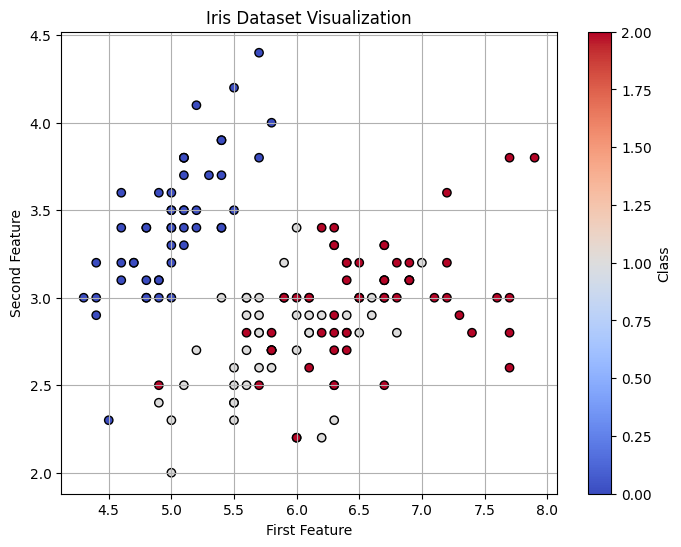

Training features shape: (112, 2)
Training labels shape: (112, 3)
Testing features shape: (38, 2)
Testing labels shape: (38, 3)


In [18]:
data = load_iris()
features = data.data[:, :2]
labels = data.target

if sklearn.__version__ >= "1.2":
    ohe = OneHotEncoder(sparse_output=False)
else:
    ohe = OneHotEncoder(sparse=False)

encoded_labels = ohe.fit_transform(labels.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap="coolwarm", edgecolor="black")
plt.title("Iris Dataset Visualization")
plt.xlabel("First Feature")
plt.ylabel("Second Feature")
plt.grid(True)
plt.colorbar(label="Class")
plt.show()

X_train, X_test, Y_train, Y_test = train_test_split(
    features, encoded_labels, test_size=0.25, random_state=123
)

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {Y_test.shape}")


Epoch 0, Loss: 0.4588
Epoch 20, Loss: 0.2835
Epoch 40, Loss: 0.2466
Epoch 60, Loss: 0.2221
Epoch 80, Loss: 0.2149
Epoch 100, Loss: 0.2129


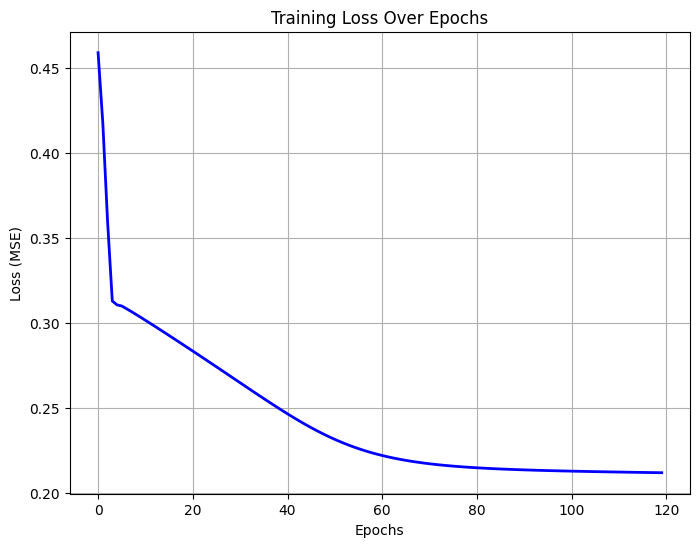

In [19]:
np.random.seed(42)
data_X = np.random.rand(60, 2)
data_Y = np.random.randint(0, 3, 60)
one_hot_labels = np.zeros((60, 3))
one_hot_labels[np.arange(60), data_Y] = 1

NN = NeuralNetwork()

training_epochs = 120
loss_history = []

for epoch in range(training_epochs):
    predictions = NN.forward_pass(data_X)
    loss = np.mean(np.square(one_hot_labels - predictions))
    loss_history.append(loss)
    NN.train(data_X, one_hot_labels)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(loss_history, color='blue', linewidth=2)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()


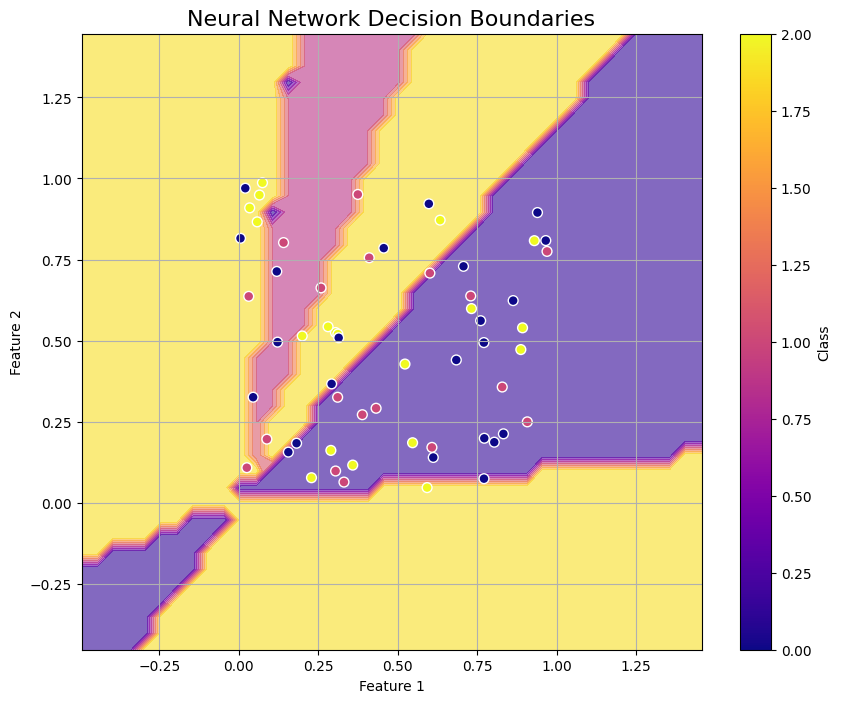

In [20]:
# Define the range for the grid
x_min, x_max = data_X[:, 0].min() - 0.5, data_X[:, 0].max() + 0.5
y_min, y_max = data_X[:, 1].min() - 0.5, data_X[:, 1].max() + 0.5

# Create a grid of points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.05),
    np.arange(y_min, y_max, 0.05)
)

# Predict on the grid points using the neural network
grid_predictions = NN.forward_pass(np.c_[xx.ravel(), yy.ravel()])
grid_predictions = np.argmax(grid_predictions, axis=1)
grid_predictions = grid_predictions.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, grid_predictions, alpha=0.6, cmap="plasma")
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_Y, cmap="plasma", edgecolor="white", s=50)
plt.title("Neural Network Decision Boundaries", fontsize=16)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()
